In [33]:
# Packages

import os
import gc
import polars as pl
import numpy as np 
import pandas as pd 
import glob
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from tqdm.auto import tqdm
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading and concatenating the whole dataset

class LoadData:
    
    def __init__(self, file_paths):
        self.file_paths = file_paths
        
    def load_and_concat(self):
        # Use `scan_parquet` for lazy loading
        partitioned_data = [pl.scan_parquet(file_path) for file_path in self.file_paths]
        df = pl.concat(partitioned_data, rechunk=False)  # Keep lazy mode with rechunk=False
        
        return df
    
# Specify file paths
file_paths = sorted(glob.glob('Data/train.parquet/*/*.parquet'))

# Initialize the loader and load data as a lazy frame
loader = LoadData(file_paths)
df_full = loader.load_and_concat()  # df_train is now a lazy frame

In [3]:
# Feature engineering the daily mean value for each responder

responder_columns = [col for col, dtype in df_full.schema.items() if col.startswith("responder_")]
aggregations = [pl.col(responder).mean().alias(f"daily_{responder}_mean") for responder in responder_columns]
df_daily_means = df_full.group_by("date_id").agg(aggregations)
df_full = df_full.join(df_daily_means, on="date_id")
df_full_collected = df_full.collect()
df_full_collected['date_id'].describe()

C:\Users\afise\AppData\Local\Temp\ipykernel_4740\873041080.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  responder_columns = [col for col, dtype in df_full.schema.items() if col.startswith("responder_")]


statistic,value
str,f64
"""count""",4.7127338e7
"""null_count""",0.0
"""mean""",1005.479389
"""std""",445.181943
"""min""",0.0
"""25%""",679.0
"""50%""",1060.0
"""75%""",1376.0
"""max""",1698.0


In [4]:
# Get the count of missing values for each column
missing_values = df_full_collected.select([pl.col(column).null_count().alias(column) for column in df_full_collected.columns])

# Transpose the missing values DataFrame to list columns with non-zero missing values
missing_values_df = missing_values.transpose(include_header=True).to_pandas()
missing_values_df.columns = ['Column', 'Null Count']

# Filter to show only columns with missing values
missing_values_filtered = missing_values_df[missing_values_df['Null Count'] > 0]

print("Columns with missing values:")
print(missing_values_filtered)

Columns with missing values:
        Column  Null Count
4   feature_00     3182052
5   feature_01     3182052
6   feature_02     3182052
7   feature_03     3182052
8   feature_04     3182052
12  feature_08      300247
19  feature_15     1209299
20  feature_16         261
21  feature_17      201838
22  feature_18         226
23  feature_19         226
25  feature_21     8435985
30  feature_26     8435985
31  feature_27     8435985
35  feature_31     8435985
36  feature_32      478457
37  feature_33      478457
41  feature_37         849
43  feature_39     4300649
44  feature_40       67856
45  feature_41     1093012
46  feature_42     4300649
47  feature_43       67856
48  feature_44     1093012
49  feature_45      317163
50  feature_46      317163
51  feature_47          87
54  feature_50     4254098
55  feature_51       13805
56  feature_52     1044898
57  feature_53     4254098
58  feature_54       13805
59  feature_55     1044898
60  feature_56         226
61  feature_57         226

In [5]:
# Set window size for daily smoothing (e.g., 400–800 timepoints)
window_size = 800

# Apply rolling mean for columns with missing values
df_full_imputed = df_full_collected.select([
    pl.col(column).fill_null(strategy="mean") if column not in missing_values_filtered else 
    pl.col(column).rolling_mean(window_size).fill_null(strategy="backward")
    for column in df_full_collected.columns
])

In [6]:
# Splitting the whole dataset into train and validation at 75th percentile of the date_id value

train_df_collected = df_full_imputed.filter(pl.col('date_id') < (np.percentile(df_full_imputed['date_id'].to_numpy(), 75)))
val_df_collected = df_full_imputed.filter(pl.col('date_id') >= (np.percentile(df_full_imputed['date_id'].to_numpy(), 75)))

len_train = len(train_df_collected)
len_valid = len(val_df_collected)

train_df = train_df_collected.lazy()
val_df = val_df_collected.lazy()

del train_df_collected
del val_df_collected
del df_full_collected
gc.collect()

0

In [9]:
# Initialize the model with adjusted hyperparameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10,         # Increased from 5 to 10
    max_depth=6,
    learning_rate=0.1,       # Increased from 0.01 to 0.1
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=1.0,          # L2 regularization
    random_state=42,
    verbosity=1
)

# Define chunk size
chunk_size = 1000000  # Increased from 50,000 to 1,000,000

# Placeholder for the existing booster
existing_model = None

# Placeholder for feature columns
feature_columns = None

# Optional: Shuffle the dataset before training to ensure representative chunks
# Uncomment the following lines if your dataset isn't already shuffled
# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Starting incremental training...")
for i in tqdm(range(0, len_train, chunk_size), desc="Training Progress", leave=True):
    # Load and process a chunk of data
    chunk = train_df.slice(i, chunk_size).collect().to_pandas()
    X_chunk = chunk.drop(columns=['responder_6'])
    y_chunk = chunk['responder_6']
    
    # Save feature columns from the first chunk
    if i == 0:
        feature_columns = X_chunk.columns.tolist()
        with open("feature_columns.pkl", "wb") as f:
            pickle.dump(feature_columns, f)
    
    # Ensure feature alignment
    X_chunk = X_chunk[feature_columns]
    
    # Define a small validation set from the current chunk
    # Here, we take 10% of the chunk as a temporary validation set
    X_val = X_chunk.sample(frac=0.1, random_state=42)
    y_val = y_chunk.loc[X_val.index]
    
    # Remove validation samples from training data
    X_train_chunk = X_chunk.drop(index=X_val.index)
    y_train_chunk = y_chunk.drop(index=X_val.index)
    
    # Fit the model incrementally with early stopping
    xgb_model.fit(
        X_train_chunk, 
        y_train_chunk, 
        xgb_model=existing_model, 
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Update the existing booster
    existing_model = xgb_model.get_booster()
    
    # Monitor total number of trees
    total_trees = xgb_model.get_booster().trees_to_dataframe().shape[0]
    print(f"Total number of trees after this chunk: {total_trees}")
    
    # Sample prediction for monitoring
    sample_pred = xgb_model.predict(X_train_chunk.sample(5))
    print(f"Sample Predictions after this chunk: {sample_pred}")
    
    # Stop training if total trees exceed 10,000 (adjust as needed)
    if total_trees >= 100000:
        print("Reached the maximum number of trees. Stopping training.")
        break

print("Training complete.")

# Save the entire model using joblib
joblib.dump(xgb_model, "xgb_baseline_model.joblib")
print("Model saved using joblib.")

Starting incremental training...


Training Progress:   0%|          | 0/36 [00:00<?, ?it/s]

Total number of trees after this chunk: 1270
Sample Predictions after this chunk: [ 0.20462534 -0.36916992  0.01501894 -0.22044249 -0.06805652]
Total number of trees after this chunk: 2540
Sample Predictions after this chunk: [-0.18113618 -0.5023955   0.15984912 -0.92642426  0.25941736]
Total number of trees after this chunk: 3810
Sample Predictions after this chunk: [ 0.6349307  -0.43176982  0.79620177 -0.7704328   0.24980852]
Total number of trees after this chunk: 5078
Sample Predictions after this chunk: [ 0.50310713 -1.2656448  -1.1523645   0.11093835 -0.2631311 ]
Total number of trees after this chunk: 6342
Sample Predictions after this chunk: [-0.6910918  -0.30661574  0.6328231   1.0926235  -0.08707051]
Total number of trees after this chunk: 7608
Sample Predictions after this chunk: [0.7951825  1.910867   1.2730012  1.7528841  0.40086818]
Total number of trees after this chunk: 8878
Sample Predictions after this chunk: [-0.27392232  0.09945485 -0.40647572  0.13719326 -0.2609938

In [13]:
# Load feature columns
with open("feature_columns.pkl", "rb") as f:
    feature_columns = pickle.load(f)

# Load the trained model using joblib
xgb_model = joblib.load("xgb_baseline_model.joblib")

# Verify that get_score exists
print("Has get_score:", hasattr(xgb_model, 'get_score'))  # Should print True

# Prepare data
val_df_collected = val_df.collect()
X_full = val_df_collected.drop('responder_6').to_pandas()
y_full = val_df_collected['responder_6'].to_pandas()

# Align features
X_full = X_full[feature_columns]

# Handle NaNs and infinite values
X_full = X_full.fillna(0).replace([np.inf, -np.inf], 0)

# Initialize TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare metrics storage
metrics = {'rmse': [], 'mae': [], 'r2': []}

fold = 1
for train_index, test_index in tscv.split(X_full):
    print(f"\nProcessing Fold {fold}...")
    
    # Split data
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    # Check for NaNs or infinite values in X_test
    if X_test.isnull().values.any():
        print("Validation data contains NaN values. Handling them now.")
        X_test = X_test.fillna(0)  # or use another appropriate strategy

    if not np.isfinite(X_test).all().all():
        print("Validation data contains infinite values. Handling them now.")
        X_test = X_test.replace([np.inf, -np.inf], 0)

    # Predict using the pre-trained model
    y_pred = xgb_model.predict(X_test)

    # Debug: print sample values
    print("Sample y_test:", y_test.head(5).values)
    print("Sample y_pred:", y_pred[:5])
    print("X_test mean:", X_test.mean().mean())
    print("X_test std deviation:", X_test.std().mean())

    # Calculate metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append metrics to storage
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['r2'].append(r2)

    # Print fold results for debugging
    print(f"Fold {fold} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R-squared: {r2:.2f}")

    fold += 1

# Aggregate results only if at least one fold was processed
if metrics['rmse']:
    print("\nCross-Validation Results:")
    print(f"Average RMSE: {np.mean(metrics['rmse']):.2f}")
    print(f"Average MAE: {np.mean(metrics['mae']):.2f}")
    print(f"Average R-squared: {np.mean(metrics['r2']):.2f}")
else:
    print("No folds were processed. Please check the split logic.")

Has get_score: False

Processing Fold 1...
Sample y_test: [-0.06528983 -0.61177075  0.01927231  0.10459156  0.04467911]
Sample y_pred: [-0.01738704 -0.2567499   0.02126453  0.08341186  0.07893153]
X_test mean: 21.682413396970198
X_test std deviation: 5.66138495646666
Fold 1 - RMSE: 0.41, MAE: 0.19, R-squared: 0.78

Processing Fold 2...


C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Sample y_test: [ 0.15286504 -0.09382491  0.19368365  0.10055123  0.5272096 ]
Sample y_pred: [ 0.08675054 -0.13341476  0.32115856  0.09249685  0.637266  ]
X_test mean: 22.199709330636484
X_test std deviation: 5.714965395513075
Fold 2 - RMSE: 0.53, MAE: 0.21, R-squared: 0.45

Processing Fold 3...


C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Sample y_test: [-0.48750278 -0.250614   -0.1543186  -0.50523615  0.2855216 ]
Sample y_pred: [-0.42615622 -0.34194    -0.27978697 -0.30642954  0.33488798]
X_test mean: 22.806088096903565
X_test std deviation: 5.65270580377582
Fold 3 - RMSE: 0.44, MAE: 0.19, R-squared: 0.72

Processing Fold 4...


C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Sample y_test: [-0.10810545  0.5540864   1.8912317   0.14390613  0.775472  ]
Sample y_pred: [-0.08534803  0.58485657  1.491108    0.02938647  0.45599654]
X_test mean: 23.304163244343997
X_test std deviation: 5.606112938028312
Fold 4 - RMSE: 0.31, MAE: 0.16, R-squared: 0.88

Processing Fold 5...


C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Sample y_test: [-0.14782311 -0.218748   -0.23136136 -0.39407742  0.1264341 ]
Sample y_pred: [-0.17599386 -0.1529113  -0.2830996  -0.36153692  0.12477134]
X_test mean: 23.907138029459773
X_test std deviation: 5.659383413591573
Fold 5 - RMSE: 0.58, MAE: 0.24, R-squared: 0.40

Cross-Validation Results:
Average RMSE: 0.45
Average MAE: 0.20
Average R-squared: 0.64


C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# Retrieve the underlying Booster object
booster = xgb_model.get_booster()

# Get feature importance scores using the 'gain' metric
feature_importance = booster.get_score(importance_type='gain')

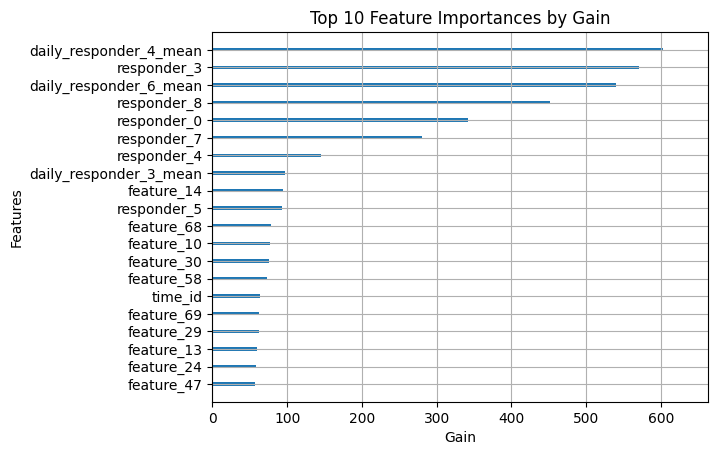

In [26]:
xgb.plot_importance(booster, importance_type='gain', show_values=False, max_num_features=20)
plt.title('Top 10 Feature Importances by Gain')
plt.ylabel('Features')
plt.xlabel('Gain')
plt.show()